Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/My Drive/TESI
Pickle file loaded successfully.
Total samples in dataset: 1997


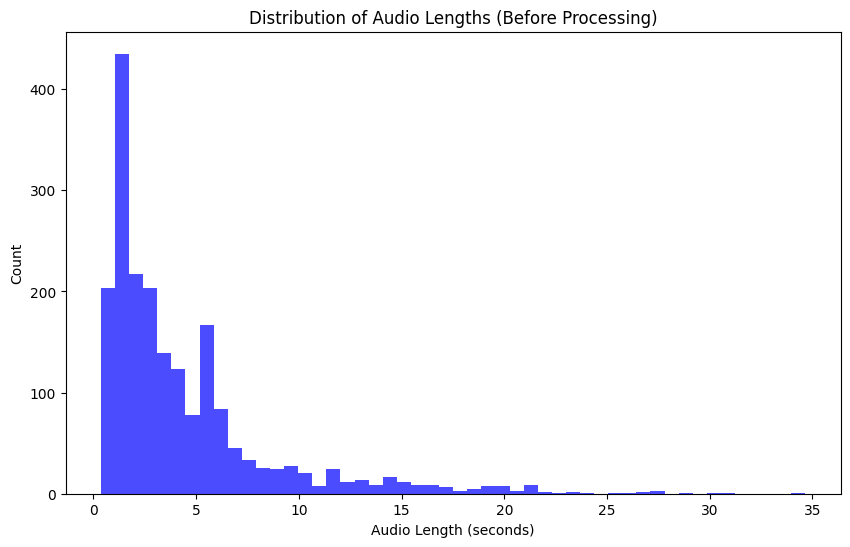

Number of audios: 1997
Minimum audio length: 0.36 seconds
Maximum audio length: 34.66 seconds


In [11]:
# ==== SECTION 0: Import Libraries and Mount Google Drive ====

# Importing necessary libraries
import os
import pickle
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix
from transformers import ASTFeatureExtractor, ASTForAudioClassification
from collections import defaultdict
from google.colab import drive  # Import Google Drive

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

# ==== SECTION 1: Data Loading and Preprocessing ====

# Set the path to your data and change the working directory
tesi_path = '/content/drive/My Drive/TESI'
os.chdir(tesi_path)  # Change to the thesis directory
print("Current working directory:", os.getcwd())

# Load the dataset from a pickle file
file_path = '/content/drive/MyDrive/TESI/newdata_updated.pkl'

with open(file_path, 'rb') as f:
    newdata = pickle.load(f)

print("Pickle file loaded successfully.")
print(f"Total samples in dataset: {len(newdata)}")

# Define the standard audio sampling rate
sampling_rate = 44100  # 44.1 kHz

# Calculate audio lengths in samples and convert to seconds
audio_lengths = [len(item['audio']) for item in newdata]
audio_lengths_sec = [length / sampling_rate for length in audio_lengths]

# Plot the distribution of audio lengths before processing
plt.figure(figsize=(10, 6))
plt.hist(audio_lengths_sec, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Audio Lengths (Before Processing)')
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Count')
plt.show()

# Print statistics about the audio lengths
print(f"Number of audios: {len(audio_lengths_sec)}")
print(f"Minimum audio length: {min(audio_lengths_sec):.2f} seconds")
print(f"Maximum audio length: {max(audio_lengths_sec):.2f} seconds")

def print_updrs_distribution(data, label_key='label', updrs_keys=['updrs', 'UPDRS']):
    """
    Prints the distribution of data based on UPDRS levels and labels.

    Args:
        data (list): Dataset containing 'label' and 'updrs' or 'UPDRS' information.
        label_key (str): Key for the label (0 = control, 1 = Parkinsonian).
        updrs_keys (list): Possible keys for the UPDRS value in the data.
    """
    # Counters for labels and UPDRS
    updrs_counts = defaultdict(int)
    control_count, parkinsonian_count = 0, 0

    for item in data:
        # Check for the presence of the label key
        if label_key in item:
            label = item[label_key]
            if label == 0:
                control_count += 1
            elif label == 1:
                parkinsonian_count += 1

        # Check for the presence of at least one UPDRS key
        updrs_value = None
        for key in updrs_keys:
            if key in item:
                updrs_value = item[key]
                break

        # Increment the count for the UPDRS level
        if updrs_value is not None:
            updrs_counts[updrs_value] += 1

    # Print results
    print(f"Number of controls: {control_count}")
    print(f"Number of Parkinsonians: {parkinsonian_count}")
    print("UPDRS Distribution:")
    for updrs_value, count in sorted(updrs_counts.items()):
        print(f"  UPDRS {updrs_value}: {count}")





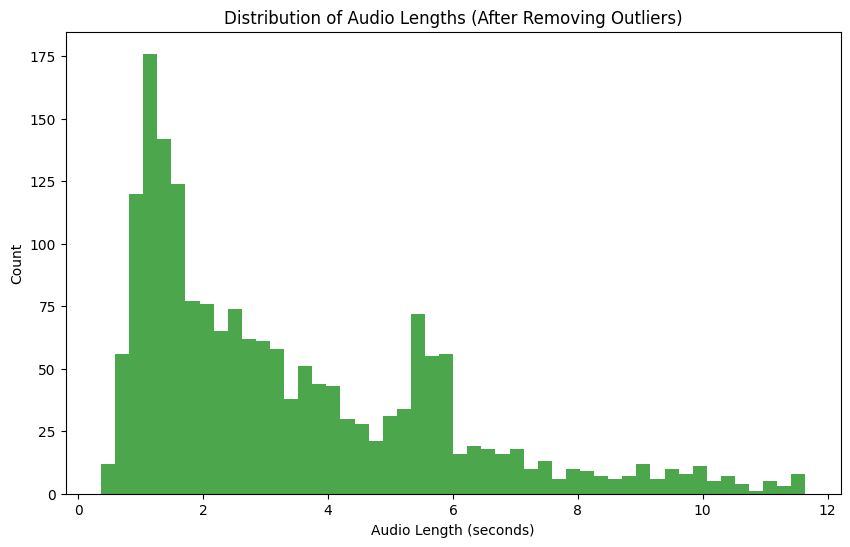

Number of audios after removing outliers: 1841
Minimum audio length after filtering: 0.36 seconds
Maximum audio length after filtering: 11.64 seconds
The shortest audio length is: 0.36 seconds (15872 samples)
Distribution BEFORE outlier removal:
Number of controls: 966
Number of Parkinsonians: 1031
UPDRS Distribution:
  UPDRS 0: 118
  UPDRS 1: 98
  UPDRS 2: 65
  UPDRS 3: 5
  UPDRS 4: 20
Distribution AFTER outlier removal:
Number of controls: 918
Number of Parkinsonians: 923
UPDRS Distribution:
  UPDRS 0: 73
  UPDRS 1: 69
  UPDRS 2: 38
  UPDRS 3: 5
  UPDRS 4: 19
Preprocessing audios...
Example audio shape: (15872,)


In [12]:

# Remove outliers based on audio length using the Interquartile Range (IQR) method
q1 = np.percentile(audio_lengths, 25)
q3 = np.percentile(audio_lengths, 75)
iqr = q3 - q1

# Define acceptable range for audio lengths
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter audios within the acceptable range
filtered_data = [item for item in newdata if lower_bound <= len(item['audio']) <= upper_bound]

# Extract lengths after filtering
filtered_audio_lengths = [len(item['audio']) for item in filtered_data]
filtered_audio_lengths_sec = [length / sampling_rate for length in filtered_audio_lengths]

# Plot the distribution after filtering
plt.figure(figsize=(10, 6))
plt.hist(filtered_audio_lengths_sec, bins=50, color='green', alpha=0.7)
plt.title('Distribution of Audio Lengths (After Removing Outliers)')
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Count')
plt.show()

# Print statistics after filtering
print(f"Number of audios after removing outliers: {len(filtered_audio_lengths_sec)}")
print(f"Minimum audio length after filtering: {min(filtered_audio_lengths_sec):.2f} seconds")
print(f"Maximum audio length after filtering: {max(filtered_audio_lengths_sec):.2f} seconds")

# Find the shortest audio length (n) in samples
min_length = min(filtered_audio_lengths)
print(f"The shortest audio length is: {min_length / sampling_rate:.2f} seconds ({min_length} samples)")

# Before removing outliers
print("Distribution BEFORE outlier removal:")
print_updrs_distribution(newdata)

# After removing outliers
print("Distribution AFTER outlier removal:")
print_updrs_distribution(filtered_data)

# Update 'newdata' to 'filtered_data' for further processing
newdata = filtered_data
# Preprocess the audios by trimming to the central part
print("Preprocessing audios...")
min_length = min([len(item['audio']) for item in newdata])
for item in newdata:
    audio_trimmed = item['audio']
    start = (len(audio_trimmed) - min_length) // 2
    end = start + min_length
    item['audio'] = audio_trimmed[start:end]  # Trim audio

# Normalize the audio data to ensure it lies within [-1, 1] range
for item in newdata:
    audio = np.array(item['audio'])
    audio = audio / np.max(np.abs(audio))  # Normalize audio
    item['audio'] = audio

# Debugging: Print shape of a sample audio
print(f"Example audio shape: {newdata[0]['audio'].shape}")

# Initialize the AST feature extractor for processing audio
feature_extractor = ASTFeatureExtractor.from_pretrained(
    'MIT/ast-finetuned-audioset-10-10-0.4593',
    sampling_rate=16000,  # Set the audio sampling rate to 16kHz
    return_attention_mask=False  # Don't use attention masks for this task
)

# ==== SECTION 2: Dataset Class Definition ====

import torch.nn as nn

# Custom dataset class for loading audio and labels
class AudioDataset(Dataset):
    def __init__(self, data, extractor, dropout_rate=0.15):
        """
        Args:
            data (list): List of samples with 'audio' and 'label' keys.
            extractor (callable): Feature extractor function.
            dropout_rate (float): Dropout probability to apply on features.
        """
        self.data = data
        self.extractor = extractor
        self.dropout = nn.Dropout(p=dropout_rate)  # Initialize dropout with specified rate

    def __len__(self):
        return len(self.data)  # Return the total number of samples

    def __getitem__(self, idx):
        sample = self.data[idx]
        audio = sample['audio']
        label = sample['label']

        # Check for 'updrs' or 'UPDRS' key
        if 'updrs' in sample:
            updrs_value = sample['updrs']
        elif 'UPDRS' in sample:
            updrs_value = sample['UPDRS']
        else:
            updrs_value = -1  # Assign -1 if no key is present

        metadata = {'updrs': updrs_value}

        # Extract features from the raw audio using ASTFeatureExtractor
        inputs = self.extractor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        input_values = inputs['input_values'].squeeze(0)  # Remove batch dimension

        # Apply dropout to the input values
        input_values = self.dropout(input_values)

        return input_values, label, metadata

# ==== SECTION 3: Stratified Group Split ====

# Function to ensure balanced stratified split between control and Parkinson subjects
def stratified_group_split(all_ids, grouped_by_id, label_key='label'):
    controls = [id_ for id_ in all_ids if grouped_by_id[id_][0][label_key] == 0]  # Control group
    parkinsons = [id_ for id_ in all_ids if grouped_by_id[id_][0][label_key] == 1]  # Parkinson group

    random.shuffle(controls)  # Shuffle to randomize
    random.shuffle(parkinsons)

    split_controls = len(controls) // 5  # Split into 5 folds
    split_parkinsons = len(parkinsons) // 5

    # Create balanced folds
    folds = []
    for i in range(5):
        fold_controls = controls[i * split_controls:(i + 1) * split_controls]
        fold_parkinsons = parkinsons[i * split_parkinsons:(i + 1) * split_parkinsons]
        folds.append(fold_controls + fold_parkinsons)

    return folds


In [13]:
def analyze_updrs(val_loader, model, device):
    """
    Analyze logits and probabilities by UPDRS levels.
    Args:
        val_loader: Validation data loader.
        model: Trained model.
        device: Device (CPU or GPU).
    Returns:
        updrs_results: Dictionary with logits, probabilities, and true labels grouped by UPDRS levels.
    """
    updrs_results = {0: [], 1: [], 2: [], 3: [], 4: []}

    # Validation phase: Calculate logits and probabilities for each UPDRS level
    with torch.no_grad():
        for inputs, labels, metadata in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits

            # Calculate probabilities and logits
            probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Probability of being Parkinsonian
            logits = outputs[:, 1]  # Logit for Parkinsonian class

            # Iterate over each sample in the batch
            for i, prob in enumerate(probabilities.cpu().numpy()):
                logit = logits[i].item()

                # Access UPDRS value from metadata if available
                updrs_value = None
                if 'updrs' in metadata:
                    updrs_value = metadata['updrs'][i]
                elif 'UPDRS' in metadata:
                    updrs_value = metadata['UPDRS'][i]

                # Convert UPDRS value to integer if it exists
                if updrs_value is not None:
                    if isinstance(updrs_value, torch.Tensor):
                        updrs_value = updrs_value.item()
                    else:
                        updrs_value = int(updrs_value)

                # Skip invalid UPDRS values
                if updrs_value == -1 or updrs_value is None:
                    continue

                # Append results to UPDRS-specific stats
                updrs_results[updrs_value].append((logit, prob, labels[i].item()))


    return updrs_results



In [14]:
def aggregate_updrs_results(fold_results):
    """
    Aggregates UPDRS results across all folds.

    Args:
        fold_results (list): List of dictionaries, where each dictionary contains
                             'updrs_results' for a fold.

    Returns:
        aggregated_results (dict): Dictionary with aggregated metrics for each UPDRS level.
                                   Keys: {0, 1, 2, 3, 4}
                                   Values: Dict with:
                                       - 'total_count': Total samples with this UPDRS level.
                                       - 'mean_probability': Mean probability for Parkinsonian classification.
                                       - 'mean_logit': Mean logit value for Parkinsonian class.
                                       - 'percentage_classified_as_parkinsonian': Percentage classified as Parkinsonian.
        probabilities_by_updrs (dict): Dictionary containing all individual probabilities for each UPDRS level.
    """
    # Initialize results dictionary for each UPDRS level
    aggregated_results = {0: [], 1: [], 2: [], 3: [], 4: []}
    probabilities_by_updrs = {0: [], 1: [], 2: [], 3: [], 4: []}

    # Collect all results from all folds
    for fold in fold_results:
        updrs_results = fold['updrs_results']
        for level, values in updrs_results.items():
            aggregated_results[level].extend(values)  # Combine results across folds
            probabilities_by_updrs[level].extend([prob for _, prob, _ in values])  # Collect probabilities

    # Calculate aggregated metrics
    metrics = {}
    for level, results in aggregated_results.items():
        if results:
            # Extract logits, probabilities, and true labels
            logits, probs, true_labels = zip(*results)
            mean_prob = np.mean(probs)  # Mean probability
            mean_logit = np.mean(logits)  # Mean logit value
            total_count = len(results)  # Total count for this UPDRS level
            classified_as_parkinsonian = sum(1 for prob, label in zip(probs, true_labels) if prob >= 0.5 and label == 1)
            percentage_classified_as_parkinsonian = (classified_as_parkinsonian / total_count) * 100

            # Store metrics
            metrics[level] = {
                'total_count': total_count,
                'mean_probability': mean_prob,
                'mean_logit': mean_logit,
                'percentage_classified_as_parkinsonian': percentage_classified_as_parkinsonian,
            }
        else:
            # Handle cases with no data for this UPDRS level
            metrics[level] = {
                'total_count': 0,
                'mean_probability': 0.0,
                'mean_logit': 0.0,
                'percentage_classified_as_parkinsonian': 0.0,
            }

    return metrics, probabilities_by_updrs



In [15]:
# ==== SECTION 6: Confusion Matrix and Metric Calculation ====

# Function to compute and print the confusion matrix and derived metrics
def compute_confusion_matrix_metrics(labels, preds, fold_num):
    cm = confusion_matrix(labels, preds)  # Compute confusion matrix
    tn, fp, fn, tp = cm.ravel()  # Extract values from the confusion matrix

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall for positive class)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    balanced_acc = (sensitivity + specificity) / 2  # Balanced accuracy

    # Print confusion matrix and derived metrics
    print(f"\nConfusion Matrix for Fold {fold_num}:")
    print(cm)
    print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, Balanced Accuracy: {balanced_acc:.4f}")

    return sensitivity, specificity, balanced_acc

In [ ]:
# ==== SECTION 7: Training Loop Over 5 Folds ====

# Set training parameters
num_epochs = 50  # Lower the number of epochs for faster training
early_stopping_patience = 5  # More aggressive early stopping
learning_rate = 1e-3  # Slightly increase learning rate for faster convergence
gamma = 0.995  # Exponential decay factor for learning rate scheduler

# Lists to store metrics across folds
fold_results = []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1s, val_f1s = [], []
train_losses, val_losses = [], []


# Define the loss function
criterion = nn.CrossEntropyLoss()

# Group data by subject ID for splitting
grouped_by_id = defaultdict(list)
for item in newdata:
    grouped_by_id[item['id']].append(item)

all_ids = list(grouped_by_id.keys())

# Perform stratified split to ensure balance
folds = stratified_group_split(all_ids, grouped_by_id)



# Loop over 5 folds to train and validate the model
for fold in range(5):
    print(f"Processing Fold {fold+1}/5...")  # Debug: indicate the current fold

    # Define training and validation IDs
    train_ids = [id_ for id_ in all_ids if id_ not in folds[fold]]  # IDs for training
    val_ids = folds[fold]  # IDs for validation

    # Extract training and validation samples based on IDs
    train_samples = [item for id_soggetto in train_ids for item in grouped_by_id[id_soggetto]]  # Training samples
    val_samples = [item for id_soggetto in val_ids for item in grouped_by_id[id_soggetto]]  # Validation samples

    print(f"Training set size: {len(train_samples)} samples")  # Print training set size
    print(f"Validation set size: {len(val_samples)} samples")  # Print validation set size

    # Create Dataset objects for training and validation
    train_dataset = AudioDataset(train_samples, feature_extractor)  # Training dataset
    val_dataset = AudioDataset(val_samples, feature_extractor)  # Validation dataset

    # Create DataLoader objects for batching
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Training DataLoader
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)  # Validation DataLoader

    # Reinitialize the AST model at the start of each fold
    model = ASTForAudioClassification.from_pretrained(
        'MIT/ast-finetuned-audioset-10-10-0.4593',  # Load the AST model
        num_labels=2,  # Set the number of output classes to 2 (Control, Parkinson)
        ignore_mismatched_sizes=True  # Ignore size mismatch in classifier layer
    )

        # Define optimizer and scheduler
    optimizer = optim.AdamW(model.classifier.parameters(), lr=learning_rate, weight_decay=0.01)  # AdamW optimizer with weight decay
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)  # Exponential decay for learning rate

    # Freeze layers except classifier and last transformer layers
    for param in model.parameters():
        param.requires_grad = False  # Freeze all layers
    for name, param in model.named_parameters():
        if 'encoder.layer.11' in name or 'encoder.layer.10' in name or 'classifier' in name:
            param.requires_grad = True  # Unfreeze last 2 layers

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
    model.to(device)  # Move model to the appropriate device (GPU/CPU)



        # Initialize training variables
    best_val_accuracy = 0
    patience_counter = 0
    best_val_loss = 0
    epoch_train_accuracies, epoch_val_accuracies = [], []
    epoch_train_precisions, epoch_val_precisions = [], []
    epoch_train_recalls, epoch_val_recalls = [], []
    epoch_train_f1s, epoch_val_f1s = [], []
    epoch_train_losses, epoch_val_losses = [], []
    val_fold_preds, val_fold_true = [], []


    # Training loop for each epoch
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs} for Fold {fold+1}")  # Debug: print current epoch number

        # TRAINING PHASE
        model.train()  # Set model to training mode
        train_loss, correct_train = 0.0, 0
        train_preds, train_true = [], []

        for inputs, labels, metadata in train_loader:  # Iterate over training batches
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs).logits  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            train_loss += loss.item() * labels.size(0)  # Accumulate training loss
            preds = torch.argmax(outputs, dim=1)  # Get predicted classes
            correct_train += torch.sum(preds == labels).item()
            train_preds.extend(preds.cpu().numpy())
            train_true.extend(labels.cpu().numpy())

        # Calculate average training loss and accuracy
        train_loss /= len(train_loader.dataset)
        train_accuracy = correct_train / len(train_loader.dataset)
        train_precision = precision_score(train_true, train_preds, zero_division=0)
        train_recall = recall_score(train_true, train_preds)
        train_f1 = f1_score(train_true, train_preds)


        # VALIDATION PHASE
        model.eval()  # Set the model to evaluation mode
        val_loss, correct_val = 0, 0  # Initialize validation loss and correct prediction counter
        val_preds, val_true = [], []  # Store all predictions and labels for the validation set

        with torch.no_grad():  # Disable gradient calculation during validation
            for inputs, labels, metadata in val_loader:  # Iterate over validation batches
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
                outputs = model(inputs).logits  # Forward pass

                loss = criterion(outputs, labels)  # Calculate validation loss

                val_loss += loss.item() * labels.size(0)  # Accumulate validation loss
                preds = torch.argmax(outputs, dim=1)  # Get predicted classes
                correct_val += torch.sum(preds == labels).item()
                val_preds.extend(preds.cpu().numpy())  # Store predictions
                val_true.extend(labels.cpu().numpy())  # Store true labels

        updrs_results = analyze_updrs(val_loader, model, device)

        # Calculate and store validation metrics
        val_loss /= len(val_loader.dataset)
          # Calculate metrics for validation
        val_accuracy = correct_val / len(val_loader.dataset)
        val_precision = precision_score(val_true, val_preds, zero_division=0)
        val_recall = recall_score(val_true, val_preds)
        val_f1 = f1_score(val_true, val_preds)
        val_sensitivity = val_recall  # Sensitivity is the same as recall in binary classification

            # Corrected specificity calculation
        true_negatives = np.sum((np.array(val_true) == 0) & (np.array(val_preds) == 0))
        false_positives = np.sum((np.array(val_true) == 0) & (np.array(val_preds) == 1))
        val_specificity = true_negatives / (true_negatives + false_positives)


        # Calculate and store validation metrics
        val_loss /= len(val_loader.dataset)
          # Calculate metrics for validation
        val_accuracy = correct_val / len(val_loader.dataset)
        val_precision = precision_score(val_true, val_preds, zero_division=0)
        val_recall = recall_score(val_true, val_preds)
        val_f1 = f1_score(val_true, val_preds)
        val_sensitivity = val_recall  # Sensitivity is the same as recall in binary classification

        # Corrected specificity calculation
        true_negatives = np.sum((np.array(val_true) == 0) & (np.array(val_preds) == 0))
        false_positives = np.sum((np.array(val_true) == 0) & (np.array(val_preds) == 1))
        val_specificity = true_negatives / (true_negatives + false_positives)


        # Append epoch metrics
        epoch_train_accuracies.append(train_accuracy)
        epoch_val_accuracies.append(val_accuracy)
        epoch_train_precisions.append(train_precision)
        epoch_val_precisions.append(val_precision)
        epoch_train_recalls.append(train_recall)
        epoch_val_recalls.append(val_recall)
        epoch_train_f1s.append(train_f1)
        epoch_val_f1s.append(val_f1)
        epoch_train_losses.append(train_loss)
        epoch_val_losses.append(val_loss)

        # Print metrics
        print(f"Fold {fold + 1}, Epoch {epoch + 1} - Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


                # ==== Early Stopping Logic ====
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pt')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")  # Indicate early stopping
                break  # Exit the epoch loop

        # Update the learning rate scheduler
        scheduler.step()  # Step the scheduler

            # Store results for this fold
    fold_results.append({
        'train_accuracy': epoch_train_accuracies,
        'val_accuracy': epoch_val_accuracies,
        'train_precision': epoch_train_precisions,
        'val_precision': epoch_val_precisions,
        'train_recall': epoch_train_recalls,
        'val_recall': epoch_val_recalls,
        'train_f1': epoch_train_f1s,
        'val_f1': epoch_val_f1s,
        'train_loss': epoch_train_losses,
        'val_loss': epoch_val_losses,
        'val_sensitivity': val_sensitivity,
        'val_specificity': val_specificity,
        'val_preds': val_fold_preds,
        'val_true': val_fold_true,
        'updrs_results': updrs_results  # Add UPDRS results here
    })

# Calculate and print final average metrics across all folds (only the last epoch of each fold)
final_train_accuracies = [result['train_accuracy'][-1] for result in fold_results]
final_val_accuracies = [result['val_accuracy'][-1] for result in fold_results]
final_train_precisions = [result['train_precision'][-1] for result in fold_results]
final_val_precisions = [result['val_precision'][-1] for result in fold_results]
final_train_recalls = [result['train_recall'][-1] for result in fold_results]
final_val_recalls = [result['val_recall'][-1] for result in fold_results]
final_train_f1s = [result['train_f1'][-1] for result in fold_results]
final_val_f1s = [result['val_f1'][-1] for result in fold_results]
final_val_sensitivities = [result['val_sensitivity'] for result in fold_results]
final_val_specificities = [result['val_specificity'] for result in fold_results]

# Calculate averages across folds
average_train_accuracy = np.mean(final_train_accuracies)
average_val_accuracy = np.mean(final_val_accuracies)
average_train_precision = np.mean(final_train_precisions)
average_val_precision = np.mean(final_val_precisions)
average_train_recall = np.mean(final_train_recalls)
average_val_recall = np.mean(final_val_recalls)
average_train_f1 = np.mean(final_train_f1s)
average_val_f1 = np.mean(final_val_f1s)
average_val_sensitivity = np.mean(final_val_sensitivities)
average_val_specificity = np.mean(final_val_specificities)

# Print final average metrics
print("\n===== Average Metrics Across Folds (Last Epoch Only) =====")
print(f"Training Accuracy: {average_train_accuracy:.4f}")
print(f"Validation Accuracy: {average_val_accuracy:.4f}")
print(f"Training Precision: {average_train_precision:.4f}")
print(f"Validation Precision: {average_val_precision:.4f}")
print(f"Training Recall: {average_train_recall:.4f}")
print(f"Validation Recall: {average_val_recall:.4f}")
print(f"Training F1-Score: {average_train_f1:.4f}")
print(f"Validation F1-Score: {average_val_f1:.4f}")
print(f"Validation Sensitivity: {average_val_sensitivity:.4f}")
print(f"Validation Specificity: {average_val_specificity:.4f}")





Processing Fold 1/5...
Training set size: 1462 samples
Validation set size: 379 samples


Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50 for Fold 1
Fold 1, Epoch 1 - Train Acc: 0.5657, Val Acc: 0.6069
Training Loss: 0.7136, Validation Loss: 0.0018
Epoch 2/50 for Fold 1
Fold 1, Epoch 2 - Train Acc: 0.6416, Val Acc: 0.6306
Training Loss: 0.6301, Validation Loss: 0.0017
Epoch 3/50 for Fold 1
Fold 1, Epoch 3 - Train Acc: 0.6772, Val Acc: 0.6069
Training Loss: 0.6006, Validation Loss: 0.0018
Epoch 4/50 for Fold 1
Fold 1, Epoch 4 - Train Acc: 0.6744, Val Acc: 0.6253
Training Loss: 0.5993, Validation Loss: 0.0016
Epoch 5/50 for Fold 1
Fold 1, Epoch 5 - Train Acc: 0.6813, Val Acc: 0.6702
Training Loss: 0.5952, Validation Loss: 0.0016
Early stopping at epoch 5
Processing Fold 2/5...
Training set size: 1464 samples
Validation set size: 377 samples


Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50 for Fold 2
Fold 2, Epoch 1 - Train Acc: 0.5499, Val Acc: 0.6525
Training Loss: 0.7189, Validation Loss: 0.0016
Epoch 2/50 for Fold 2
Fold 2, Epoch 2 - Train Acc: 0.6243, Val Acc: 0.6844
Training Loss: 0.6425, Validation Loss: 0.0016
Epoch 3/50 for Fold 2
Fold 2, Epoch 3 - Train Acc: 0.6462, Val Acc: 0.7029
Training Loss: 0.6233, Validation Loss: 0.0015
Epoch 4/50 for Fold 2
Fold 2, Epoch 4 - Train Acc: 0.6796, Val Acc: 0.6605
Training Loss: 0.6007, Validation Loss: 0.0016
Epoch 5/50 for Fold 2
Fold 2, Epoch 5 - Train Acc: 0.6612, Val Acc: 0.6817
Training Loss: 0.5967, Validation Loss: 0.0015
Early stopping at epoch 5
Processing Fold 3/5...
Training set size: 1495 samples
Validation set size: 346 samples


Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50 for Fold 3
Fold 3, Epoch 1 - Train Acc: 0.5291, Val Acc: 0.5636
Training Loss: 0.7229, Validation Loss: 0.0020
Epoch 2/50 for Fold 3
Fold 3, Epoch 2 - Train Acc: 0.6488, Val Acc: 0.5723
Training Loss: 0.6297, Validation Loss: 0.0020
Epoch 3/50 for Fold 3
Fold 3, Epoch 3 - Train Acc: 0.6756, Val Acc: 0.6243
Training Loss: 0.6034, Validation Loss: 0.0019
Epoch 4/50 for Fold 3
Fold 3, Epoch 4 - Train Acc: 0.6916, Val Acc: 0.6156
Training Loss: 0.5840, Validation Loss: 0.0019
Epoch 5/50 for Fold 3
Fold 3, Epoch 5 - Train Acc: 0.6849, Val Acc: 0.6012
Training Loss: 0.5735, Validation Loss: 0.0020
Early stopping at epoch 5
Processing Fold 4/5...
Training set size: 1477 samples
Validation set size: 364 samples


Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50 for Fold 4
Fold 4, Epoch 1 - Train Acc: 0.6181, Val Acc: 0.4451
Training Loss: 0.6457, Validation Loss: 0.0023
Epoch 2/50 for Fold 4
Fold 4, Epoch 2 - Train Acc: 0.7028, Val Acc: 0.4038
Training Loss: 0.5752, Validation Loss: 0.0023
Epoch 3/50 for Fold 4
Fold 4, Epoch 3 - Train Acc: 0.7123, Val Acc: 0.5137
Training Loss: 0.5566, Validation Loss: 0.0026
Epoch 4/50 for Fold 4
Fold 4, Epoch 4 - Train Acc: 0.7265, Val Acc: 0.4753
Training Loss: 0.5393, Validation Loss: 0.0023
Epoch 5/50 for Fold 4
Fold 4, Epoch 5 - Train Acc: 0.7387, Val Acc: 0.4615
Training Loss: 0.5263, Validation Loss: 0.0024
Early stopping at epoch 5
Processing Fold 5/5...
Training set size: 1504 samples
Validation set size: 337 samples


Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50 for Fold 5
Fold 5, Epoch 1 - Train Acc: 0.5698, Val Acc: 0.6706
Training Loss: 0.6846, Validation Loss: 0.0018
Epoch 2/50 for Fold 5
Fold 5, Epoch 2 - Train Acc: 0.6270, Val Acc: 0.7270
Training Loss: 0.6405, Validation Loss: 0.0017
Epoch 3/50 for Fold 5
Fold 5, Epoch 3 - Train Acc: 0.6589, Val Acc: 0.7181
Training Loss: 0.6074, Validation Loss: 0.0017
Epoch 4/50 for Fold 5


In [ ]:
# Dopo il ciclo di cross-validation
aggregated_updrs_metrics, probabilities_by_updrs = aggregate_updrs_results(fold_results)

# Stampa dei risultati aggregati
print("\n===== Aggregated UPDRS Metrics Across Folds =====")
for level, metrics in aggregated_updrs_metrics.items():
    print(f"UPDRS Level {level}:")
    print(f"  Total Count: {metrics['total_count']}")
    print(f"  Mean Probability (Parkinsonian): {metrics['mean_probability']:.4f}")
    print(f"  Percentage Classified as Parkinsonian: {metrics['percentage_classified_as_parkinsonian']:.2f}%")
    print("-" * 40)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_updrs_metrics(aggregated_updrs_metrics, probabilities_by_updrs):
    # Prepare data for plotting
    levels = list(aggregated_updrs_metrics.keys())
    total_counts = [aggregated_updrs_metrics[level]['total_count'] for level in levels]
    mean_probs = [aggregated_updrs_metrics[level]['mean_probability'] for level in levels]
    mean_logits = [aggregated_updrs_metrics[level]['mean_logit'] for level in levels]
    percentages_classified = [aggregated_updrs_metrics[level]['percentage_classified_as_parkinsonian'] for level in levels]

    # Bar chart for mean probabilities
    plt.figure(figsize=(10, 6))
    sns.barplot(x=levels, y=mean_probs, palette='Blues_d')
    plt.xlabel('UPDRS Level')
    plt.ylabel('Mean Probability')
    plt.title('Mean Probability of Being Classified as Parkinsonian by UPDRS Level')
    plt.show()

    # Boxplot for probabilities
    plt.figure(figsize=(10, 6))
    data = [(level, prob) for level, probs in probabilities_by_updrs.items() for prob in probs]
    df = pd.DataFrame(data, columns=['UPDRS Level', 'Probability'])
    sns.boxplot(x='UPDRS Level', y='Probability', data=df, palette='Pastel1')
    plt.xlabel('UPDRS Level')
    plt.ylabel('Probability')
    plt.title('Distribution of Probabilities by UPDRS Level')
    plt.show()

    # Bar chart for percentage classified as Parkinsonian
    plt.figure(figsize=(10, 6))
    sns.barplot(x=levels, y=percentages_classified, palette='Oranges_d')
    plt.xlabel('UPDRS Level')
    plt.ylabel('Percentage Classified as Parkinsonian')
    plt.title('Percentage Classified as Parkinsonian by UPDRS Level')
    plt.show()

    # Bar chart for total count
    plt.figure(figsize=(10, 6))
    sns.barplot(x=levels, y=total_counts, palette='Greens_d')
    plt.xlabel('UPDRS Level')
    plt.ylabel('Total Count')
    plt.title('Total Data Count by UPDRS Level')
    plt.show()

# Call the function after calculating metrics
plot_updrs_metrics(aggregated_updrs_metrics, probabilities_by_updrs)


In [ ]:
# Nome del file per salvare tutti i risultati
results_filename = "results_AST2.txt"

# Scrivi tutti i risultati in un unico file
with open(results_filename, mode="w") as file:
    # Scrivi i risultati UPDRS
    file.write("===== Aggregated UPDRS Metrics Across Folds =====\n")
    for level, metrics in aggregated_updrs_metrics.items():
        file.write(f"UPDRS Level {level}:\n")
        file.write(f"  Total Count: {metrics['total_count']}\n")
        file.write(f"  Mean Probability (Parkinsonian): {metrics['mean_probability']:.4f}\n")
        file.write(f"  Percentage Classified as Parkinsonian: {metrics['percentage_classified_as_parkinsonian']:.2f}%\n")
        file.write("-" * 40 + "\n")

    # Scrivi le metriche medie sui fold
    file.write("\n===== Average Metrics Across Folds (Last Epoch Only) =====\n")
    file.write(f"Training Accuracy: {average_train_accuracy:.4f}\n")
    file.write(f"Validation Accuracy: {average_val_accuracy:.4f}\n")
    file.write(f"Training Precision: {average_train_precision:.4f}\n")
    file.write(f"Validation Precision: {average_val_precision:.4f}\n")
    file.write(f"Training Recall: {average_train_recall:.4f}\n")
    file.write(f"Validation Recall: {average_val_recall:.4f}\n")
    file.write(f"Training F1-Score: {average_train_f1:.4f}\n")
    file.write(f"Validation F1-Score: {average_val_f1:.4f}\n")
    file.write(f"Validation Sensitivity: {average_val_sensitivity:.4f}\n")
    file.write(f"Validation Specificity: {average_val_specificity:.4f}\n")

print(f"All results saved to {results_filename}")